In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2gray, rgba2rgb
from skimage import io, data
from scipy import linalg

# Exercise 1: Singular Value Decomposition of a Picture
## RGB to grayscale
This example converts an image with RGB channels into an image with a single grayscale channel.

The value of each grayscale pixel is calculated as the weighted sum of the corresponding red, green and blue pixels as:
```
Y = 0.2125 R + 0.7154 G + 0.0721 B
```
These weights are used by CRT phosphors as they better represent human perception of red, green and blue than equal weights. 1

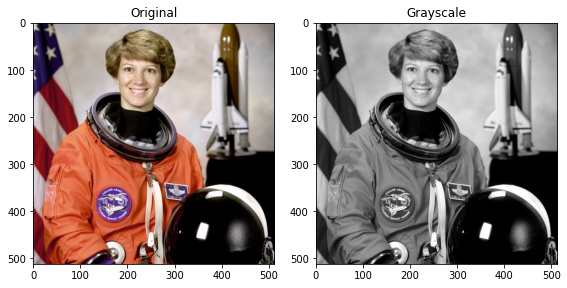

In [7]:
# Astronaut image from scipy
original = data.astronaut()
grayscale = rgb2gray(original)

# Python icon image, located in the resources folder
# image_path = os.path.join('resources', 'python_icon.png')
# original = io.imread(image_path)
# grayscale = rgb2gray(rgba2rgb(original))


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()

## Singular Value Decomposition for grayscale images
Factorizes the matrix A into two unitary matrices U and Vh, and a 1-D array s of singular values (real, non-negative) such that A == U @ diag(s) @ Vh.

Now we can take only a part of the calculated matrices to get U_r, S_r & Vh_r.
* U_r := first r-columns of U
* S_r := diagonal matrix of the first r singular values
* Vh_r := first r-rows of Vh

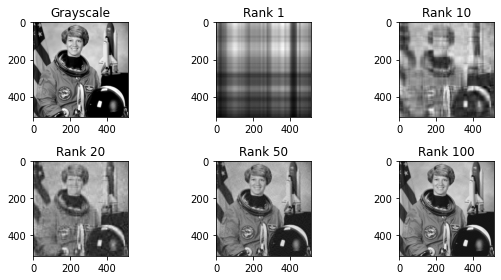

In [8]:
A = grayscale
ranks = [1, 10, 20 ,50 ,100]

n_rows = 2
fig, axes = plt.subplots(n_rows, int((len(ranks)+1)/n_rows), figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(A, cmap=plt.cm.gray)
ax[0].set_title("Grayscale")

# SVD
U, s, Vh = linalg.svd(grayscale)

for index, rank in enumerate(ranks):
    U_r = U[:, :rank]
    S_r = np.diag(s[:rank])
    Vh_r = Vh[:rank, :]

    A_r = U_r @ S_r @ Vh_r

    ax[index+1].imshow(A_r, cmap=plt.cm.gray)
    ax[index+1].set_title(f"Rank {rank}")


fig.tight_layout()
plt.show()


The amount of data needed to store the approximation of a matrix A of size n,m can be calculated as:

compressed size = m x r + r + r x n = r x (1 + m + n)

In [9]:
m = A.shape[0]
n = A.shape[1]

size = m*n
print(f'The uncompressed image needs to store {m} * {n} = {size} values.')

for rank in ranks:
    size_r = rank * (1 + m + n)
    print(f'r = {rank}: compressed size = {rank} * (1 + {m} + {n}) = {size_r}')
    print(f'Rate c = {size_r/size * 100:.2f}%')

The uncompressed image needs to store 512 * 512 = 262144 values.
r = 1: compressed size = 1 * (1 + 512 + 512) = 1025
Rate c = 0.39%
r = 10: compressed size = 10 * (1 + 512 + 512) = 10250
Rate c = 3.91%
r = 20: compressed size = 20 * (1 + 512 + 512) = 20500
Rate c = 7.82%
r = 50: compressed size = 50 * (1 + 512 + 512) = 51250
Rate c = 19.55%
r = 100: compressed size = 100 * (1 + 512 + 512) = 102500
Rate c = 39.10%


But actually grayscale images are a little bit sad.
So let's do the same for each (color) channel to approximate a colored image.

## Singular Value Decomposition for colored images
The amount of data needed to store the approximation of a image of size n,m,q can be calculated as:

compressed size = q * (m x r + r + r x n) = c * r x (1 + m + n)
with q is the number of color channels e.g for rgb: q = 3, rgba: q = 4.

The uncompressed image needs to store 3 * 512 * 512 = 786432 values.
r = 1: compressed size = 3 * 1 * (1 + 512 + 512) = 3075
Rate c = 0.39%
r = 10: compressed size = 3 * 10 * (1 + 512 + 512) = 30750
Rate c = 3.91%
r = 20: compressed size = 3 * 20 * (1 + 512 + 512) = 61500
Rate c = 7.82%
r = 50: compressed size = 3 * 50 * (1 + 512 + 512) = 153750
Rate c = 19.55%
r = 100: compressed size = 3 * 100 * (1 + 512 + 512) = 307500
Rate c = 39.10%


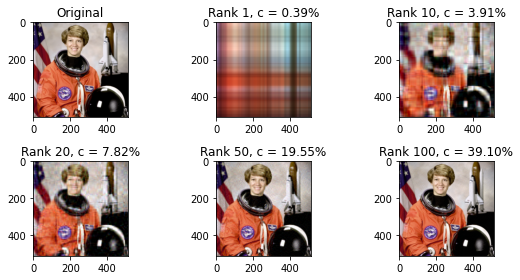

In [10]:
rgb_image = original/255. # normalize channels to [0.0-1.0]

n = rgb_image.shape[0]
m = rgb_image.shape[1]
q = rgb_image.shape[2]

ranks = [1, 10, 20, 50, 100]

size = q*m*n
print(f'The uncompressed image needs to store {q} * {n} * {m} = {size} values.')

n_rows = 2
fig, axes = plt.subplots(n_rows, int((len(ranks)+1)/n_rows), figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(rgb_image)
ax[0].set_title(f"Original")

rgb_image_r = np.ndarray([n,m, q])

for index, rank in enumerate(ranks):
    size_r = q * rank * (1 + m + n)
    print(f'r = {rank}: compressed size = {q} * {rank} * (1 + {m} + {n}) = {size_r}')
    print(f'Rate c = {size_r/size * 100:.2f}%')

    for channel, A in enumerate(np.moveaxis(rgb_image, -1, 0)):
        U, s, Vh = linalg.svd(A)

        U_r = U[:, :rank]
        S_r = np.diag(s[:rank])
        Vh_r = Vh[:rank, :]

        A_r = U_r @ S_r @ Vh_r

        rgb_image_r[:,:, channel] = A_r

    rgb_image_r = np.clip(rgb_image_r, 0, 1) # Due to SVD our image has slightly bigger values than 1, so clip it.
    ax[index+1].imshow(rgb_image_r)
    ax[index+1].set_title(f"Rank {rank}, c = {size_r/size * 100:.2f}%")


fig.tight_layout()
plt.show()